##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [6]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os  
try:
    pool.close()
    print('poolClose')
except:pass

poolClose


# Model

In [ ]:

MP=True
Scope = 'Full'
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
Target='fch4'
Inputs=['Sedge','VWC','Grass','Temp']
#     for FillVar in ['fco2','fch4']:
# Runs,params = Dense.Params(Scope,Target,MP)
params = Dense.Params(Scope,Target,MP)

params['Dpath'] = cwd+'/'+Site+'/'
params['Spath'] = params['Dpath']+'/TempWeights/'
params['Sname'] = 'Test'
params['Inputs'] = Inputs
params['Model'] = '+'.join(params['Inputs'])

# params['Loss']='mean_absolute_error'

if __name__ == '__main__':
    if params['proc']>1:
        pool = Pool(processes=3,maxtasksperchild=75)
    else:
        pool = None
    
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')
    RST.Scale(params['target'],params['Inputs'])
    y = RST.y*1.0
    X = RST.X*1.0
    
    params['N']=int(y.shape[0]/30)
    
    Y_hat,y_true,X_true,index,ones = Dense.RunNN(params,X,y,RST.YScaled,RST.XScaled,pool)
    Y_hat,y_true = np.squeeze(Y_hat),np.squeeze(y_true)
    
    print(Y_hat.shape,y_true.shape,X_true.shape,index.shape,ones.shape)
    

    if pool is not None:
        pool.close()
        print('Pool Closed!')
      
    
print('Done!!')

0.31333333333333335
Epoch 00036: early stopping
Epoch 00051: early stopping
Epoch 00091: early stopping
Saved model to disk
Epoch 00156: early stopping
Epoch 00103: early stopping
Epoch 00168: early stopping
Epoch 00055: early stopping
Epoch 00062: early stopping
Epoch 00066: early stopping
Epoch 00065: early stopping
Epoch 00091: early stopping
Epoch 00092: early stopping
Epoch 00071: early stopping
Epoch 00074: early stopping
Epoch 00105: early stopping
Epoch 00088: early stopping
Epoch 00080: early stopping
Epoch 00177: early stopping
Epoch 00085: early stopping
Epoch 00052: early stopping


# Sorting

In [3]:
def Sort(Y_hat,y_true,X_true,index,ones):
# print(params)
    SortKey = np.argsort(index)
    ones_train = ones+0.0
    ones_val = ones*-1+1.0
    count_train = ones_train
    count_val = ones_val
    ones_train[ones_train==0] = np.nan
    ones_val[ones_val==0] = np.nan
    Y_hat_train = Y_hat.copy()*ones_train
    Y_hat_val = Y_hat.copy()*ones_val
    y_true2 = y_true.copy()
    X_true2 = X_true.copy()
    index2 = index.copy()

    for I in range(SortKey.shape[0]):
        Y_hat_train[I,:]=Y_hat_train[I,SortKey[I]]
        Y_hat_val[I,:]=Y_hat_val[I,SortKey[I]]
        y_true2[I,:]=y_true[I,SortKey[I]]
        for J in range(X_true2.shape[-1]):
            X_true2[I,:,J]=X_true[I,SortKey[I],J]
        index2[I,:]=index[I,SortKey[I]]
        count_train[I,:] = count_train[I,SortKey[I]]
        count_val[I,:] = count_val[I,SortKey[I]]
        
    return(Y_hat_train,Y_hat_val,y_true2,
           X_true2[0,:,],count_train,count_val)

Y_hat_train,Y_hat_val,y_true2,X_true2,count_train,count_val=Sort(Y_hat,
                                                                 y_true,X_true,index,ones)    
    
Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)
Y_hat_val_bar=np.nanmean(Y_hat_val,axis=0)
Y_hat_train_var = 1/(np.nansum(count_train)-1)*np.nansum((Y_hat_train - Y_hat_train_bar)**2,axis=0)
Y_hat_val_var = 1/(np.nansum(count_val)-1)*np.nansum((Y_hat_val - Y_hat_val_bar)**2,axis=0)

r2_train = np.maximum((y_true2[0,:]-Y_hat_train_bar)**2-Y_hat_train_var,0)
r2_val = np.maximum((y_true2[0,:]-Y_hat_val_bar)**2-Y_hat_val_var,0)


plt.figure()
plt.scatter(y_true2[0,:],Y_hat_train_bar)
print(metrics.mean_squared_error(y_true2[0,:],Y_hat_train_bar))
print(metrics.r2_score(y_true2[0,:],Y_hat_train_bar))

# 0.14512486468280644 - No Constant
# 0.6168961888151867

# 0.14516044551997273
# 0.6168022617382979


NameError: name 'Y_hat' is not defined

# CI and PI

<IPython.core.display.Javascript object>


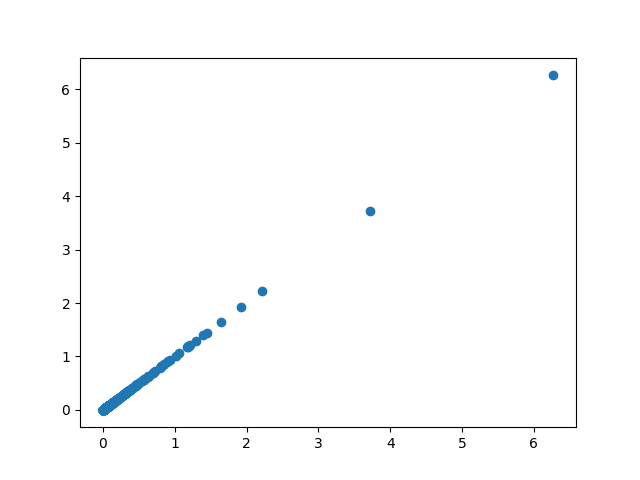

Saved model to disk
(409, 1) (409, 1)


In [4]:

importlib.reload(Dense)


params['Loss'] = 'Boot_Loss'
params['Validate'] = False
params['Sname'] = 'Var'
params['Save']['Model'] = True

y = r2_val
# plt.figure()
# # plt.plot(np.nansum((Y_hat_val - Y_hat_val_bar)**2,axis=0),
# #          np.nansum((Y_hat_val - Y_hat_val_bar)**2,axis=0))
# plt.scatter(r2_val,r2_val)
Valid = np.where(np.isnan(y)==False)
y = y[Valid]
X = X_true2[Valid]

YStandard = MinMaxScaler(feature_range=(.1, 1))
XStandard = StandardScaler()
YScaled = YStandard.fit(y.reshape(-1, 1))
XScaled = XStandard.fit(X)#.reshape(-1, 1))
y = YScaled.transform(y.reshape(-1, 1))
X = XScaled.transform(X)
init=1#int(np.random.rand(1)[0]*100)
Y_hat_var,y_true_var,X_true_var,index_var,ones_var = Dense.TTV_Split(init,params,X,y)
print(Y_hat_var.shape,y_true_var.shape)
Y_hat_var = YScaled.inverse_transform(Y_hat_var.reshape(-1,1))
y_true_var = YScaled.inverse_transform(y_true_var.reshape(-1,1))
# plt.figure()
# plt.scatter(Y_hat_var,y_true_var)
# plt.ylabel('True')
# plt.xlabel('prd')

# Map Results

(870, 2)
(870, 1)


<IPython.core.display.Javascript object>


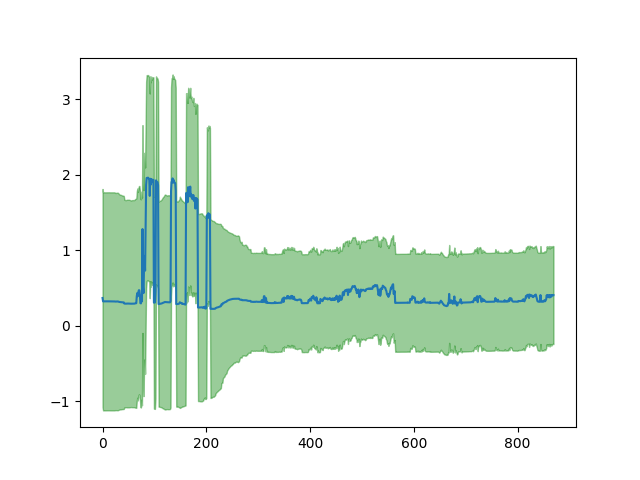

In [5]:
X = RST.XScaled.transform(X_true2)
print(X.shape)
params['Sname']='Test'
params['Loss']='mean_absolute_error'
Empty_Mod = Dense.Load_Model(params)
Model = Dense.Load_Weights(Empty_Mod,params) 
Yfill=RST.YScaled.inverse_transform(Model.predict(X).reshape(-1,1))


params['Sname']='Var'
params['Loss']='Boot_Loss'
Empty_Mod = Dense.Load_Model(params)
Model = Dense.Load_Weights(Empty_Mod,params) 
YVar=YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
X_back = np.squeeze(XScaled.inverse_transform(X))

print(Yfill.shape)
plt.figure()
# plt.plot(Yfill)
Data = pd.DataFrame(data=X_back,columns=params['Inputs'])
Data[Target] = np.squeeze(Yfill)
Data['Var'] = np.squeeze(YVar)
# Data = pd.DataFrame({'PPFD':X_back,Target:np.squeeze(Yfill),'Var':np.squeeze(YVar)})
Data['Var']=1.96*(Data['Var']**.5)
Map_Val='VWC'
# Data = Data.sort_values(by=Map_Val)
plt.plot(Data.index,Data[Target])
plt.fill_between(Data.index, Data[Target]-Data['Var'], Data[Target]+Data['Var'],  color = 'green', alpha = 0.4, label = '95% CI')
# plt.scatter(Data[Map_Val],Data['Var'])

In [ ]:

def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
#         BaseFactors = ['Sedge','Shrub','Grass','Sparse','Out_of_Basin']
#         BaseFactors = []
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','wind_speed']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)


def Curve(x,a,b,c):
    return (a*x**2+b*x+c)

def TTV_Split(iteration,Memory,X,y,params,X_fill):
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val)

def RunReps(Model,params,pool = None,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MAE = []
    R2 =[]
    Y_fill = []
    if params['Prelim_N']==True:
        params['N']=int(y.shape[0]*.8/30)
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MAE.append(metrics.mean_absolute_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MAE.append(metrics.mean_absolute_error(y_val,Yval))
            R2.append(metrics.r2_score(y_val,Yval))
            
            
    
    tempK = params['K']+0
    params['K']=1

    params['Loss'] = 'Variance_Loss'
    y = Yfill.std(axis=0)**2
    X = X_fill

    results = TTV_Split(i,Memory,X,y,params,X_fill)
    params['K'] = tempK
    Y_var = (RST.YScaled.inverse_transform(results[0][0].reshape(-1,1))).mean(axis=-1)
#         Yval=RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
#         y_val=RST.YScaled.inverse_transform(results[1].reshape(-1,1))
#         print(Y_var.shape)
    MSE_Boot = ((Yfill-Yfill_bar)**2).sum(axis=0)
    SE = stats.t.ppf(1-0.025,params['K'])*(1/(params['K']-1)*(MSE_Boot))**.5
    PI = 1.96*Y_var**.5
    print(SE.shape)
    RST.Master['CI'] = SE
    RST.Master['PI'] = Y_var
    plt.figure()
    plt.bar(RST.Master.index,RST.Master['TempFill'],RST.Master['PI'])
            
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    return(MAE,R2,RST.Master['TempFill'])

def RunLoop(Runs,model):
    style = {'description_width': 'initial'}
    f = FloatProgress(min=0, max=Runs['N'].count(),description='Finding Best N:',style=style) # instantiate the bar
    display(f) # display the bar
    i = 0
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(model,params,pool)
        MAE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MAE']=MAE
        Runs.loc[Runs['N']==N,'R2']=R2
        f.value+=params['K']
        MAE = Runs.loc[Runs['MAE']!=0].groupby('N').mean()#.values[0]
        MAE['se'] = Runs.loc[Runs['MAE']!=0,['N','MAE']].groupby('N').sem()#.values[0]
        Val = MAE['MAE'].min()+MAE.loc[MAE['MAE']==MAE['MAE'].min(),'se'].values[0]
        if i > 2:
            if np.asanyarray(MAE).mean()>Val:
                Runs = Runs.loc[Runs['MAE']!=0]
                print('Leaving at ',N)
                break
        i+=1                
    return(Runs)

def N_Nodes(Runs,params,model,plot=False):
    params['Prelim_N']=False
    Runs = RunLoop(Runs,model)
    Group = Runs.groupby('N').mean()
    Group['Count'] = Runs[['N','MAE']].groupby('N').count()
    Group['SD'] = Runs[['N','MAE']].groupby('N').std()
    Group['SE'] = Runs[['N','MAE']].groupby('N').sem()
    Group = Group.reset_index()
    Min = Group.loc[Group['MAE']==Group['MAE'].min()]
    popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MAE'].values)
    N = np.arange(Runs['N'].min(),Runs['N'].max())
    Fit = Curve(N,*popt)
    Max = (Min['MAE']+Min['SE']).values[0]
    try:
        params['N']=N[Fit<Max].min()
    except:
        print('Fitting failed to produce meaningful results')
        params['N'] = Group.loc[Group['MAE']<+Min['MAE'].values[0]+Min['SE'].values[0],'N'].values[0]
        pass
    
    if plot == True:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.scatter(Runs['N'],Runs['MAE'])
        ax.plot(N,Fit,color='r')
        ax.plot(N,N*0+Max,color = 'black')
        plt.grid()
        plt.show()
    return(params,Runs,Group)

def FactorTest(params,FullModel,Runs):
    prog1 = FloatProgress(min=0, max=len(FullModel)-1,description='FactorTesting:') # instantiate the bar
    display(prog1) # display the bar
    Scores = pd.DataFrame()
    ModelRuns = pd.DataFrame()
    Start = 1
    for level in range(Start,len(FullModel)+1):
        if level == 1:
            Models = MF.Combos(FullModel,level)
        else:
            Models = MF.Combos(FullModel,level,factor = Best)
        print('Number of Models: ',len(Models))
        prog2 = FloatProgress(min=0, max=len(Models),description='Level: '+str(level)) # instantiate the bar
        display(prog2) # display the bar
        Values = []
        for j,model in enumerate(Models):
            key = str(level)+'_'+str(j)
            Name = '+'.join(model)
            Results = RunReps(model,params,pool)
            MAE = Results[0]
            R2 = Results[1]
            d = {'Model':'+'.join(model),'MAE':MAE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
            score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
            Scores = Scores.append(score,ignore_index=True)## Might cause problems in older versions
            ModelRuns['Model: '+'+'.join(model)] = Results[2]    
            prog2.value+=1
        Group = Scores.groupby('Key').agg({'Model': 'first','Level': 'first','MAE': 'mean','R2': 'mean'}) 
        Group['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
        Min = Group.loc[Group['Level']==level]
#         print(Min)
        Mod2Beat = Min.loc[Min['MAE'] == Min['MAE'].min()]
        print('Best Model @ Level ',level)
        print(Mod2Beat)
        if level>Start:
            print('Should we exit??', (Mod2Beat['MAE']+Mod2Beat['SE']).values[0],LastMin)
            if (Mod2Beat['MAE']+Mod2Beat['SE']).values[0]>LastMin:
                print('Exit Early')
                Scores = Scores.loc[Scores['Level']<level]
                break
        LastMin = Min['MAE'].min()
        Best = Mod2Beat['Model'].values
        prog1.value+=1
    Group = Scores.groupby('Key').agg({'Model': 'first','Level': 'first','MAE': 'mean','R2': 'mean'})
    Group['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]
    return(Best,Scores,ModelRuns)

def Best_Fill(Best,Runs,Scores,params):
    N = Runs['N']
    NRuns = Runs*0
    NRuns['N']=N
    model = Best[0].split('+')

    params,Runs,Group = N_Nodes(NRuns,params,model,plot=True)
    level = 0
    key = '0_'+str(params['N'])
    Name = '+'.join(Best)
    Results = RunReps(model,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    d = {'Model':'+'.join(model),'MAE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
    score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
    Scores = Scores.append(score,ignore_index=True)
    ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
    print(params['N'])
    return(Scores,ModelRuns)

# The "Optimum" Sized Model

In [ ]:
# pool.close()
# Site = 'Illisarvik'#'FishIsland'#
Scope = 'Test'
cwd = os.getcwd()
def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
#         BaseFactors = ['Sedge','Shrub','Grass','Sparse','Out_of_Basin']
#         BaseFactors = []
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','wind_speed']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)

# def Params(Func,Y,MP = True):
#     params = {}
#     params['proc']=3
#     if MP == False:
#         params['proc']=1
#     if Func == 'Full':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(200,20,10,dtype='int32')
#     elif Func == 'Test':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(70,10,5,dtype='int32')
#     N = np.repeat(N,K)
#     d = {'N':N.astype(int)}
#     Runs = pd.DataFrame(data=d)
#     Runs['MAE'] = 0.0
#     Runs['R2'] = 0.0
#     Runs['Model']=0
#     params['K'] = K
#     params['epochs'] = epochs
#     params['Y'] = Y
#     params['splits_per_mod'] = splits_per_mod
#     params['Save'] = {}
#     params['Save']['Weights']=False
#     params['Save']['Model']=False
    
#     return(Runs,params)


# MP=False

# if Scope == 'Full':
#     MP = True
# if __name__=='__main__'and MP==True:
#     pool = Pool(processes=3,maxtasksperchild=75)
# else:pool=None
    
# # for Site in ['Illisarvik','FishIsland']:
# Site='Illisarvik'
# FillVar = 'fco2'
# #     for FillVar in ['fco2','fch4']:
# Runs,params = MF.Params(Scope,FillVar,MP)
# FullModel = ModSelect(Scope,Site)
# print(FullModel)
# params['Dpath'] = cwd+'/'+Site+'/'
# params['Prelim_N']=True
# Best,Scores,ModelRuns = MF.FactorTest(params,FullModel,Runs)
# print(Best,Scores)
# Scores,ModelRuns = Best_Fill(Best,Runs,Scores,params)
# Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
# ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')

# if __name__=='__main__'and MP==True:
#     pool.close()

In [ ]:
# Grp = Scores.groupby('Model').mean()
# Grp['SE'] = Scores[['Model','MAE']].groupby('Model').sem()
# # Grp['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
# print(Grp)
# # plt.bar(Grp.index,Grp['MAE'],yerr=Grp['SE'])

In [ ]:
print('kitty')